In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Load tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, activations, models, initializers, regularizers, constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Convolution1D, Conv1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate, BatchNormalization, Bidirectional, LSTM, Flatten, Permute, Concatenate, Reshape
from tensorflow.keras.models import load_model, Model, Sequential

# Load Sklearn utilities
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# custom modules
from utils import *
from cf_matrix import *
from data import get_tsfel_features


from livelossplot import PlotLossesKeras

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## MITBIH Model

In [5]:
WINDOW_SIZE = 187
NO_CLASSES = 5
SAMPLING_RATE = 125.0

### Load data

In [13]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [14]:
print("Train", X.shape, Y.shape)
print("Test", X_test.shape, Y_test.shape)

Train (87554, 187, 1) (87554,)
Test (21892, 187, 1) (21892,)


### Feature extraction
Extract Fourier Features using the TSFEL library

In [15]:
X_train_spectral, X_test_spectral = get_tsfel_features(
    X, X_test,
    domain="spectral",
    njobs=32, # adjust to available number of cores on your system
    sampling_rate=SAMPLING_RATE
)

100%|██████████| 21892/21892 [00:10<00:00, 2167.38it/s]


In [16]:
X_train_temporal, X_test_temporal = get_tsfel_features(
    X, X_test,
    domain="temporal",
    njobs=32, # adjust to available number of cores on your system
    sampling_rate=SAMPLING_RATE
)

100%|██████████| 21892/21892 [00:06<00:00, 3520.34it/s]


In [17]:
X_train_features = pd.concat([X_train_spectral, X_train_temporal], axis=1)
X_test_features = pd.concat([X_test_spectral, X_test_temporal], axis=1)

In [18]:
X_train_features.shape, X_test_features.shape

((87554, 192), (21892, 192))

### Class weights
Compute and visualize class weights

In [19]:
cls_weights = class_weight.compute_class_weight('balanced', classes = np.unique(Y),  y = Y)
cls_weight_dict = dict(enumerate(cls_weights))

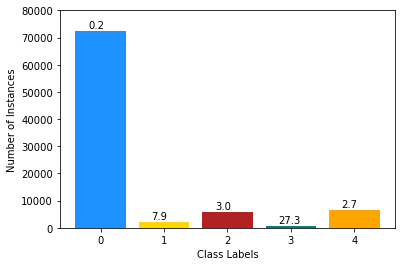

In [20]:
# plot class distribution
colors = ["dodgerblue", "gold", "firebrick", "teal", "orange"]
x = np.arange(0,5)
h, bins = np.histogram(Y, 5)
plt.bar(x, h, color=colors)
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.xticks(x)
plt.ylim(0, 80000)

for index, value in enumerate(h):
    plt.text(x[index]-0.2, value+1000, str(np.round(cls_weight_dict[index],1)))

plt.show()

### Class-wise distribution plots

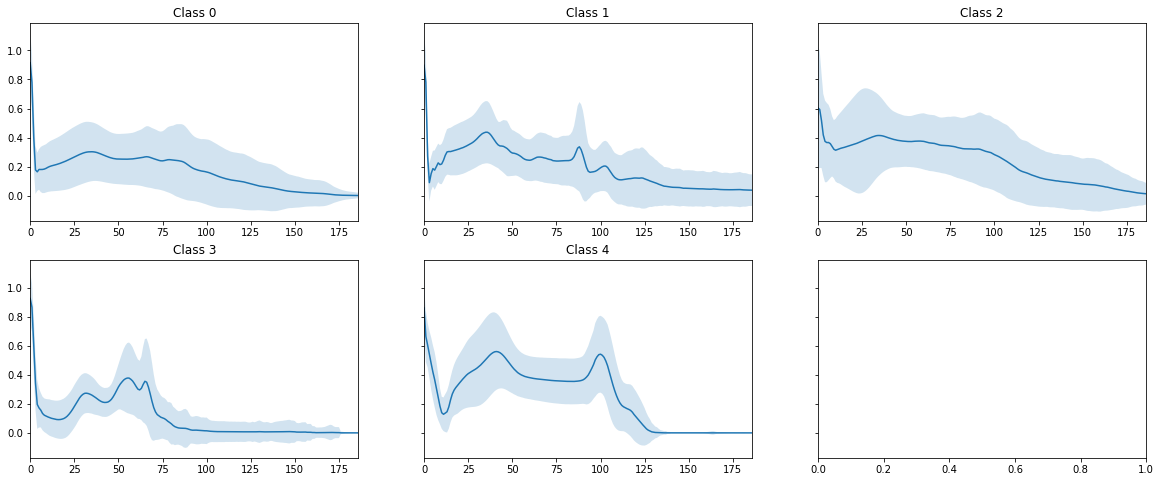

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(20,8))

for cid, ax in enumerate(axes.flatten()[:5]):
    hb_plot(ax, X[Y==cid].squeeze())
    ax.set_title("Class {}".format(cid))

## CNN with Attention Heads

#### Custom Attention Layer
Learns a projection and a context vector to pay attention to different parts of the input e.g. pay attention to different filters

Based on this implementation: (https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2) and adapted to support multiple contexts

In [23]:
# Attention with learned Context vector (https://gist.github.com/cbaziotis/7ef97ccf71cbc14366835198c09809d2)
# Adapted to use multiple contexts vectors u 
# Added support for different keys for different context vectors

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, no_contexts=1, multiple_projections=False, verbose=False, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        
        self.no_contexts = no_contexts
        self.verbose = verbose
        self.multiple_projections = multiple_projections if no_contexts != 1 else False
        
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        if self.multiple_projections:
            w_shape = (self.no_contexts, input_shape[-1], input_shape[-1])
            b_shape = (self.no_contexts, input_shape[-1])
        else:
            w_shape = (input_shape[-1], input_shape[-1],)
            b_shape = (input_shape[-1],)
            
        self.W = self.add_weight(shape=w_shape,
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=b_shape,
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                   constraint=self.b_constraint)
            
        u_shape = (input_shape[-1],) if self.no_contexts == 1 else (input_shape[-1], self.no_contexts)
        self.u = self.add_weight(shape=u_shape,
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    # TODO: implement reasonably
    def get_config(self):
        return {}

    def call(self, x, mask=None):
        
        if self.verbose: print("X", x.shape)
        if self.verbose: print("W", self.W.shape)
        
        if self.multiple_projections:
            uit = tf.map_fn(fn=lambda t: dot_product(x, t), elems=self.W)
            if self.verbose: print("uit", uit.shape)
            if self.bias:
                if self.verbose: print("b", self.b.shape)
                uit = tf.map_fn(
                    fn=lambda t: t[0] + t[1], elems=(uit, self.b),
                    fn_output_signature=tf.float32)
                    
        else:
            uit = dot_product(x, self.W)
            if self.bias:
                uit += self.b

        

        uit = K.tanh(uit)
        
        if self.verbose: print("uit shape", uit.shape)
        if self.verbose: print("u shape", self.u.shape)
        
#         ait = K.dot(uit, self.u)
        if self.no_contexts == 1:
            ait = dot_product(uit, self.u) # for TF
        else:
            if self.multiple_projections:
                u_trans = tf.transpose(self.u)
                if self.verbose: print("u trans shape", u_trans.shape)
                
                @tf.autograph.experimental.do_not_convert
                def tuple_dot(x, y):
                    return dot_product(x, y)
                
                ait = tf.map_fn(
                    fn=lambda t: tuple_dot(t[0], t[1]),
                    elems=(uit, u_trans),
                    fn_output_signature=tf.float32
                )
                
                ait = tf.transpose(ait, perm=(1, 2, 0))
                
                if self.verbose: print("ait", ait.shape)
            else:
                ait = dot_product(uit, K.transpose(self.u)) # for TF

        a = K.exp(ait) # (Batch, #filters)
        
        
        if self.verbose: print("Softmax weights shape:", a.shape)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        if self.verbose: print("Normalized a", a.shape)

        if self.no_contexts == 1:
            a = K.expand_dims(a)
        
#         print("Expanded a", a.shape)
        
        def multiple_context_weighting(a):
            a = K.expand_dims(a)
            return x * a
        
        if self.no_contexts == 1:
            weighted_input = x * a
        else:
            a_trans = tf.transpose(a, perm=(2,0,1))
            if self.verbose: print("a trans", a_trans.shape)
            weighted_input = tf.map_fn(fn=multiple_context_weighting, elems=a_trans)   
            weighted_input = tf.transpose(weighted_input, perm=(1,2,3,0))
        
        if self.verbose: print("Weighted input", weighted_input.shape)
        
        res = K.sum(weighted_input, axis=1)
        
#         print("res", res.shape)
        
        return res

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

### Custom CNN architecture
Based on the baseline CNN with additional dense connections to the extracted fourier features and attention layers to pay attention to different filters and the extracted features

In [32]:
def get_model(no_features=0):
    
    nclass = NO_CLASSES
    inp = Input(shape=(187, 1))
    
    # --------------------------------
    # CNN
    # --------------------------------
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    
    
    # Original Head
#     img_1 = GlobalMaxPool1D()(img_1)
#     img_1 = Dropout(rate=0.2)(img_1)
#     dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    
    # --------------------------------
    # Attention
    # --------------------------------
    perm_1 = Permute((2, 1))(img_1)
    att_1 = AttentionWithContext(
        name="filter_attention",
        no_contexts=NO_CLASSES * 2,
        multiple_projections=True,
        verbose=False,
    )(perm_1)
    flatt_1 = Flatten()(att_1)
    drop_1 = Dropout(rate=0.2)(flatt_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(drop_1)
    
    
    # --------------------------------
    # Extracted Features
    # --------------------------------
    inp_features = Input(shape=(no_features,))
    dense_f_1 = Dense(128, activation=activations.relu, name="dense_f_1")(inp_features)
    drop_f_2 = Dropout(rate=0.2)(dense_f_1)
    dense_f_3 = Dense(64, activation=activations.relu, name="dense_f_2")(drop_f_2)
    
    # --------------------------------
    # Concat CNN and tabular
    # --------------------------------
    dense_1 = Concatenate()([dense_1, dense_f_3])
    resh_1 = Reshape((2, 64))(dense_1)
    att_2 = AttentionWithContext(
        name="concat_attention",
        verbose=False,
    )(resh_1)
    
    
    # --------------------------------
    # Dense Head
    # --------------------------------
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(att_2)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=(inp, inp_features), outputs=dense_1)
    
    return model

In [33]:
# Get model
model = get_model(X_train_features.shape[1])

##### Compile Model

In [34]:
# Compile model
opt = optimizers.Adam(0.001)
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

##### Fit model

In [35]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path = "./models/attention_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(weight_file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat] # , PlotLossesKeras()]

In [36]:
EPOCHS = 1000
BATCH_SIZE = 128

In [ ]:
model.fit(
    (X, X_train_features), Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,  
    validation_split=0.1,
    shuffle=True,
)

#### Evaluation

In [58]:
# load best weights (based on validation accuracy)
model.load_weights(weight_file_path)

In [ ]:
pred_test_proba = model.predict((X_test, X_test_features))
pred_test = np.argmax(pred_test_proba, axis=-1)

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test, pred_test)

#### Store predictions

In [40]:
np.save("./predictions/test_mitbih_attention_cnn", pred_test, allow_pickle=True)
np.save("./predictions/test_mitbih_proba_attention_cnn", pred_test_proba, allow_pickle=True)

In [41]:
pred_test_proba = model.predict((X, X_train_features))
pred_test = np.argmax(pred_test_proba, axis=-1)
np.save("./predictions/train_mitbih_attention_cnn", pred_test, allow_pickle=True)
np.save("./predictions/train_mitbih_proba_attention_cnn", pred_test_proba, allow_pickle=True)

# PTB

#### Load data

In [135]:
df_1_ptb = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2_ptb = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df_ptb = pd.concat([df_1_ptb, df_2_ptb])

df_train_ptb, df_test_ptb = train_test_split(df_ptb, test_size=0.2, random_state=1337, stratify=df_ptb[187])


Y_ptb = np.array(df_train_ptb[187].values).astype(np.int8)
X_ptb = np.array(df_train_ptb[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test_ptb[187].values).astype(np.int8)
X_test_ptb = np.array(df_test_ptb[list(range(187))].values)[..., np.newaxis]

#### Extract Features

In [136]:
X_train_ptb_spectral, X_test_ptb_spectral = get_tsfel_features(
    X_ptb, X_test_ptb,
    domain="spectral",
    njobs=32, # adjust to available number of cores
    sampling_rate=SAMPLING_RATE
)

100%|██████████| 2911/2911 [00:01<00:00, 1928.16it/s]


In [137]:
X_train_ptb_temporal, X_test_ptb_temporal = get_tsfel_features(
    X_ptb, X_test_ptb,
    domain="temporal",
    njobs=32, # adjust to available number of cores
    sampling_rate=SAMPLING_RATE
)

100%|██████████| 2911/2911 [00:00<00:00, 3689.00it/s]


In [138]:
X_train_ptb_features = pd.concat([X_train_ptb_spectral, X_train_ptb_temporal], axis=1)
X_test_ptb_features = pd.concat([X_test_ptb_spectral, X_test_ptb_temporal], axis=1)

### Training

In [161]:
TRANSFER = False # configure to use transfer learning or not

When transfer learning we initialize the weights with the pretrained ones from the MITBIH dataset, train the complete network on the new data and use learning rate scheduling, early stopping to prevent overfitting

#### Model setup

In [162]:
model_ptb_raw = get_model(X_train_features.shape[1])

In [163]:
opt_ptb = optimizers.Adam(0.001)
model_ptb_raw.compile(optimizer=opt_ptb, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
# model.summary()

In [164]:
# Load weights from MITBIH for transfer learning (comment out if training purely)
if TRANSFER:
    print("Loading pretrained weights from MITBIH dataset")
    model_ptb_raw.load_weights(weight_file_path)

#### Reconfigure model
Reconfigure the model to have binary classification head instead of 5 classes

In [165]:
new_out = Dense(1, activation=activations.sigmoid, name="ptb_sigmoid")(model_ptb_raw.layers[-2].output)

model_ptb = Model(inputs=model_ptb_raw.input, outputs=new_out)
# model_ptb.summary()
model_ptb.compile(optimizer=opt_ptb, loss=losses.BinaryCrossentropy(), metrics=['acc'])

#### Fitting

In [166]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path_ptb = "./models/attention_cnn_ptb_transfer.h5"
checkpoint = ModelCheckpoint(weight_file_path_ptb, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat] # , PlotLossesKeras()]

In [167]:
model_ptb.fit(
    (X_ptb, X_train_ptb_features), Y_ptb, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,  
    validation_split=0.1,
    shuffle=True,
)

Epoch 1/1000
82/82 [==============================] - 5s 36ms/step - loss: 3.0152 - acc: 0.6734 - val_loss: 0.5986 - val_acc: 0.6996

Epoch 00001: val_acc improved from -inf to 0.69957, saving model to ./models/attention_cnn_ptb_transfer.h5
Epoch 2/1000
82/82 [==============================] - 2s 30ms/step - loss: 0.4408 - acc: 0.7870 - val_loss: 0.8645 - val_acc: 0.6996

Epoch 00002: val_acc did not improve from 0.69957
Epoch 3/1000
82/82 [==============================] - 3s 31ms/step - loss: 0.3098 - acc: 0.8644 - val_loss: 1.0803 - val_acc: 0.6996

Epoch 00003: val_acc did not improve from 0.69957
Epoch 4/1000
82/82 [==============================] - 2s 30ms/step - loss: 0.2439 - acc: 0.9012 - val_loss: 1.3895 - val_acc: 0.6996

Epoch 00004: val_acc did not improve from 0.69957
Epoch 5/1000
82/82 [==============================] - 3s 31ms/step - loss: 0.2159 - acc: 0.9054 - val_loss: 1.1965 - val_acc: 0.7021

Epoch 00005: val_acc improved from 0.69957 to 0.70215, saving model to ./

#### Evaluation

In [168]:
# load best weights
model_ptb.load_weights(weight_file_path_ptb)

f1 score micro:           0.99244
f1 score macro:           0.99055
accuracy score:           0.99244
balanced accuracy score:  0.98868
AuPR score:               0.99823
AuROC score:              0.99742


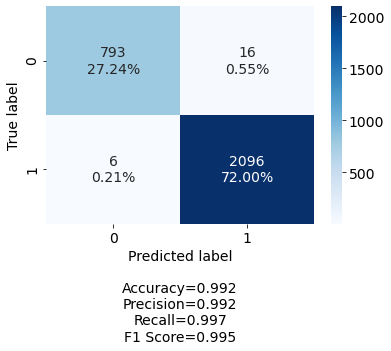

In [169]:
pred_test_proba = model_ptb.predict((X_test_ptb, X_test_ptb_features))
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test_ptb, pred_test, curve=True, proba=pred_test_proba)

#### Store predictions

In [170]:
transfer_str = "_transfer" if TRANSFER else ""

In [171]:
np.save(f"./predictions/test_ptb_attention_cnn{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/test_ptb_proba_attention_cnn{transfer_str}", pred_test_proba, allow_pickle=True)

In [172]:
pred_test_proba = model_ptb.predict((X_ptb, X_train_ptb_features))
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]
np.save(f"./predictions/train_ptb_attention_cnn{transfer_str}", pred_test, allow_pickle=True)
np.save(f"./predictions/train_ptb_proba_attention_cnn{transfer_str}", pred_test_proba, allow_pickle=True)